# **LeNet5 Model Implementation**

Note: Skip the 'Initialize model' part if not interested in retraining the model

### **Group Pogi**
*   Programmed the model
    *   Cabo, Elias Ezar
*   Researched the model (layer structure and trainable parameters)
    *   Cabo, Elias Ezar
    *   Villegas, Lex
*   Trained and tested the model
    *   Villegas, Lex
    *   Salibio, John Paul
*  Data Prerpocessing and Cleanup
    *   Sabarre, Christian
    *   Salibio, John Paul



In [1]:
import codecs
import os
import zipfile as zp
import requests
import shutil 
import gzip
import struct
import numpy as np
import matplotlib.pyplot as plt
import string
import random
import tensorflow as tf
import cv2 as cv
import pandas as pd

In [2]:
!git clone https://github.com/eliasezar27/LeNet5_implemetation.git

Cloning into 'LeNet5_implemetation'...


In [3]:
# Dataset Source: http://www.itl.nist.gov/iaui/vip/cs_links/EMNIST/gzip.zip
base_dir = './elec3_dataset'
zip_file = 'gzip.zip'
zip_file2 = 'baybayin_dataset.zip'
gzipFldr_path = os.path.join(base_dir, 'gzip')

try:
  os.mkdir(base_dir)
except:
  pass

### Fetch and unzip the EMNIST dataset using the link provided

In [4]:
url = 'http://www.itl.nist.gov/iaui/vip/cs_links/EMNIST/gzip.zip'
r = requests.get(url, allow_redirects=True)
opn_zipFile = open(os.path.join(base_dir, zip_file), 'wb')
opn_zipFile.write(r.content)

561753746

In [5]:
with zp.ZipFile(os.path.join(base_dir, zip_file), 'r') as zip_ref:
    zip_ref.extractall(base_dir)

### Fetch and unzip the Baybayin Dataset

In [6]:
url = 'https://github.com/eliasezar27/LeNet5_implemetation/blob/main/baybayin_dataset.zip'
r = requests.get(url, allow_redirects=True)
opn_zipFile = open(os.path.join(base_dir, zip_file2), 'wb')
opn_zipFile.write(r.content)

160760

In [7]:
with zp.ZipFile('./LeNet5_implemetation/baybayin_dataset.zip', 'r') as zip_ref:
    zip_ref.extractall(base_dir)

### Define Functions

In [8]:
def read_idx(file):
  print('Processing data from %s.' % file)
  with gzip.open(file, 'rb') as f:
    z, dtype, dim = struct.unpack('>HBB', f.read(4))
    print('Dimensions: ', dim)
    shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dim))
    print("Shape: ", shape)
    return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

In [9]:
def load_mnist(dl_path):
  train_images = os.path.join(dl_path, 'emnist-letters-train-images-idx3-ubyte.gz')
  train_labels = os.path.join(dl_path, 'emnist-letters-train-labels-idx1-ubyte.gz')
  test_images = os.path.join(dl_path, 'emnist-letters-test-images-idx3-ubyte.gz')
  test_labels = os.path.join(dl_path, 'emnist-letters-test-labels-idx1-ubyte.gz')

  train_x = read_idx(train_images)
  train_y = read_idx(train_labels)

  test_x = read_idx(test_images)
  test_y = read_idx(test_labels)

  return (train_x, train_y, test_x, test_y)

In [10]:
def load_baybayin(dl_path):
  train_images = os.path.join(dl_path, 'train-images-idx3-ubyte.gz')
  train_labels = os.path.join(dl_path, 'train-labels-idx1-ubyte.gz')
  test_images = os.path.join(dl_path, 'test-images-idx3-ubyte.gz')
  test_labels = os.path.join(dl_path, 'test-labels-idx1-ubyte.gz')

  train_x = read_idx(train_images)
  train_y = read_idx(train_labels)

  test_x = read_idx(test_images)
  test_y = read_idx(test_labels)

  return (train_x, train_y, test_x, test_y)

In [11]:
def show_shapes(x1, y1, x2, y2, digit = True):
    n = 'Digit' if digit else 'Alphabet'

    print('Mnist ', n, ' Dataset shapes: ')
    print('train X: ', x1.shape)
    print('train Y: ', y1.shape)
    print('test X: ', x2.shape)
    print('test Y: ',y2.shape)

def show_shapes2(x1, y1, x2, y2):
    print('Baybayin Dataset shapes: ')
    print('train X: ', x1.shape)
    print('train Y: ', y1.shape)
    print('test X: ', x2.shape)
    print('test Y: ',y2.shape)

In [12]:
def transpose_image(data):
    out = [j for j in range(len(data))]
    for i in range(len(data)):
        out[i] = data[i].T

    return np.array(out)

In [13]:
def show_data(image,label, digit = True):
    if digit: 
        rndm_digit = random.choice(list(range(0,9)))
        sample_index = random.choice(list(np.where(label == rndm_digit)[0]))
        label_list = list(i for i in range(0,10))
        title_txt = 'digit'
        data_val = str(label_list[label[sample_index]])
    else:
        rndm_letter = random.choice(list(range(1,27)))
        sample_index = random.choice(list(np.where(label == rndm_letter)[0]))
        label_list = list(string.ascii_lowercase)
        title_txt = 'letter'
        data_val = str(label_list[label[sample_index]-1])

    plt.imshow(image[sample_index].reshape((28,28)), cmap=plt.cm.binary)
    plt.colorbar()
    plt.title('The '+ title_txt+' is: '+ data_val)
    plt.show()

    return image[sample_index]

def show_data2(image,label):
    rndm_letter = random.choice(list(range(0,17)))
    sample_index = random.choice(list(np.where(label == rndm_letter)[0]))
    label_list = ['a', 'ba', 'dara', 'ei', 'ga', 'ha', 'ka', 'la', 'ma', 'na', 'nga', 'ou', 'pa', 'sa', 'ta', 'wa', 'ya']
    title_txt = 'letter'
    data_val = str(label_list[label[sample_index]])

    plt.imshow(image[sample_index].reshape((28,28)), cmap=plt.cm.binary)
    plt.colorbar()
    plt.title('The '+ title_txt+' is: '+ data_val)
    plt.show()

    return image[sample_index]

In [14]:
def plot_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

## **Emnist Letters**
Source: http://www.itl.nist.gov/iaui/vip/cs_links/EMNIST/gzip.zip	

arXiv:1702.05373
---

Description: The used Alphabet dataset for alphabet classification is the combination of capital and small letters

In [15]:
# Load Emnist alphabet Dataset

train_x_letters, train_y_letters, test_x_letters, test_y_letters = load_mnist(gzipFldr_path)

Processing data from ./elec3_dataset\gzip\emnist-letters-train-images-idx3-ubyte.gz.
Dimensions:  3
Shape:  (124800, 28, 28)
Processing data from ./elec3_dataset\gzip\emnist-letters-train-labels-idx1-ubyte.gz.
Dimensions:  1
Shape:  (124800,)
Processing data from ./elec3_dataset\gzip\emnist-letters-test-images-idx3-ubyte.gz.
Dimensions:  3
Shape:  (20800, 28, 28)
Processing data from ./elec3_dataset\gzip\emnist-letters-test-labels-idx1-ubyte.gz.
Dimensions:  1
Shape:  (20800,)


In [16]:
# Transforming Image

train_x_letters = transpose_image(train_x_letters)
test_x_letters = transpose_image(test_x_letters)

train_x_letters = train_x_letters.astype('float32')
test_x_letters = test_x_letters.astype('float32')

train_x_letters /= 255.0
test_x_letters /= 255.0

In [17]:
show_shapes(train_x_letters, train_y_letters, test_x_letters, test_y_letters, False)

Mnist  Alphabet  Dataset shapes: 
train X:  (124800, 28, 28)
train Y:  (124800,)
test X:  (20800, 28, 28)
test Y:  (20800,)


### Display random image dataset

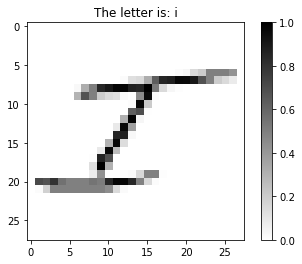

In [18]:
# Randomly show image from training dataset
img = show_data(train_x_letters, train_y_letters, digit = False)

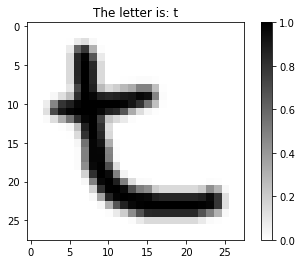

In [19]:
# Randomly show image from testing dataset
img = show_data(test_x_letters, test_y_letters, digit = False)


In [20]:
# Adjust shapes of data

# train set / data 
train_x_letters = np.expand_dims(train_x_letters, axis=-1)

# validation set / data 
test_x_letters = np.expand_dims(test_x_letters, axis=-1)

show_shapes(train_x_letters, train_y_letters, test_x_letters, test_y_letters, False)

Mnist  Alphabet  Dataset shapes: 
train X:  (124800, 28, 28, 1)
train Y:  (124800,)
test X:  (20800, 28, 28, 1)
test Y:  (20800,)


## **Mnist Digits**

In [21]:
# Load MNIST dataset using tensorflow

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

show_shapes(x_train, y_train, x_test, y_test)

# x_train.shape, y_train.shape: (60000, 28, 28) (60000,)
# x_test.shape,  y_test.shape : (10000, 28, 28) (10000,)

Mnist  Digit  Dataset shapes: 
train X:  (60000, 28, 28)
train Y:  (60000,)
test X:  (10000, 28, 28)
test Y:  (10000,)


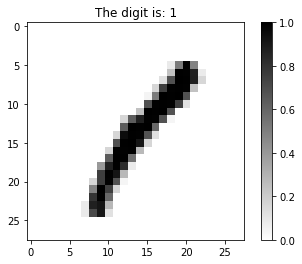

In [22]:
img = show_data(x_train, y_train)

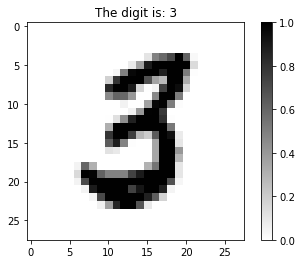

In [23]:
img = show_data(x_test, y_test)

In [24]:
# Adjust shapes of data

# train set / data 
x_train = np.expand_dims(x_train, axis=-1)

# validation set / data 
x_test = np.expand_dims(x_test, axis=-1)

show_shapes(x_train, y_train, x_test, y_test)

Mnist  Digit  Dataset shapes: 
train X:  (60000, 28, 28, 1)
train Y:  (60000,)
test X:  (10000, 28, 28, 1)
test Y:  (10000,)


## **Baybayin Dataset**
Source: https://data.mendeley.com/datasets/j6cgcfys77/1	

Daday, Mark Jovic (2020), “Handwritten Baybayin Symbols Dataset”, Mendeley Data, V1, doi: 10.17632/j6cgcfys77.1
---

Description: The Baybayin or “Alibata” became existing around year 1200’s. Baybayin was also approved in the house of congress in the Philippines to be a national writing system of the Philippines with a House bill No. of 1022. The extinct symbols are classified as syllabaries in the study of writing systems. The Philippine syllabaries have 17 signs representing 14 consonants which composed of ba, da, ka, ga, la, ha, ma, nga, na, sa, pa, wa, ya, ta, and 3 standalone vowels composes of a, i, and u at some late point the Mangyan’s added ra. The dataset contains 36,000 handwritten baybayin symbols data set.

In [25]:
# Load Baybayin Dataset

train_x_baybayin, train_y_baybayin, test_x_baybayin, test_y_baybayin = load_baybayin(base_dir)

Processing data from ./elec3_dataset\train-images-idx3-ubyte.gz.
Dimensions:  3
Shape:  (30600, 28, 28)
Processing data from ./elec3_dataset\train-labels-idx1-ubyte.gz.
Dimensions:  1
Shape:  (30600,)
Processing data from ./elec3_dataset\test-images-idx3-ubyte.gz.
Dimensions:  3
Shape:  (5400, 28, 28)
Processing data from ./elec3_dataset\test-labels-idx1-ubyte.gz.
Dimensions:  1
Shape:  (5400,)


In [26]:
# Transforming Image

train_x_baybayin = train_x_baybayin.astype('float32')
test_x_baybayin = test_x_baybayin.astype('float32')

train_x_baybayin /= 255.0
test_x_baybayin /= 255.0

In [27]:
show_shapes2(train_x_baybayin, train_y_baybayin, test_x_baybayin, test_y_baybayin)

Baybayin Dataset shapes: 
train X:  (30600, 28, 28)
train Y:  (30600,)
test X:  (5400, 28, 28)
test Y:  (5400,)


### Display random image dataset

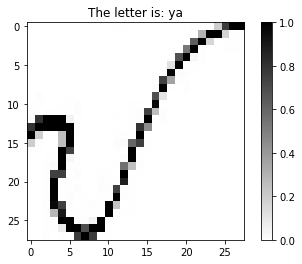

In [28]:
# Randomly show image from training dataset
img = show_data2(train_x_baybayin, train_y_baybayin)

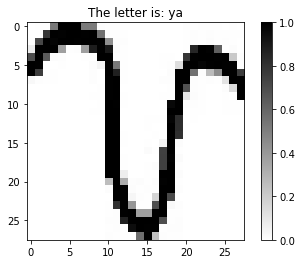

In [29]:
# Randomly show image from testing dataset
img = show_data2(test_x_baybayin, test_y_baybayin)

# **Initialize model**

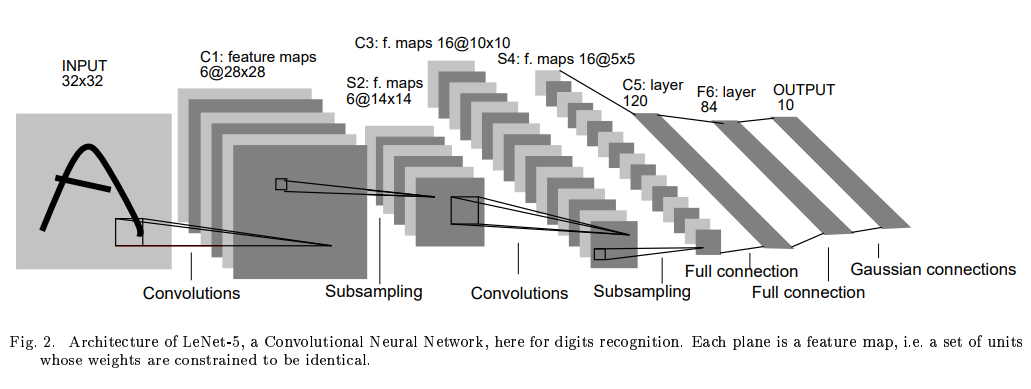

LeCun et al. (1998)

http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf

In [30]:
from tensorflow.keras import Model, layers, Input, optimizers

In [32]:
# Create a LeNet 5 model class

class LeNetFive(Model):
    def __init__(self, num_classes, name=''):
        super(LeNetFive, self).__init__()
        self.modelName = name
        self.inputSz = (32, 32, 1)

        # define all layers in init

        #Preprocess
        self.reshapeInp = layers.Resizing(self.inputSz[0], self.inputSz[0], name='resize_input')

        # Input layer
        layers.InputLayer(input_shape=(self.inputSz), name='Input')

        # First Convolutional Layer
        self.conv1 = layers.Conv2D(filters=6, kernel_size=5, strides=1, activation='tanh', name='c1')
        self.avg_pool1  = layers.AveragePooling2D(pool_size=2, strides=2, name='s2')

        # Second Convolutional Layer
        self.conv2 = layers.Conv2D(filters=16, kernel_size=5, strides=1, activation='tanh', name='c3')
        self.avg_pool2  = layers.AveragePooling2D(pool_size=2, strides=2, name='s4')

        # Fully connected layers
        self.conv3 = layers.Conv2D(120, 5, activation='tanh', name='c5')
        self.flat = layers.Flatten(name='flat')
        self.dense1 = layers.Dense(84, activation='tanh', name='f6')
        self.dense2 = layers.Dense(num_classes, activation='softmax', name='output')


    def call(self, input_tensor, training=False):
        x = self.reshapeInp(input_tensor)

        # forward pass: First layer 
        x = self.conv1(x)
        x = self.avg_pool1(x)

        # forward pass: Second layer 
        x = self.conv2(x)
        x = self.avg_pool2(x)

        # Fully connected layers
        x = self.conv3(x)
        x = self.flat(x)
        x = self.dense1(x)
        return self.dense2(x)

    def leNetModel(self):
        # Model attributes to tf Model class

        self.inpTensor = Input(shape=(28,28,1), name='InputLayer')
        x1 = self.inpTensor
        return Model(inputs=[x1], outputs=self.call(x1), name=self.modelName)

## Instantiate and Train LesNet5 for Digit classification

In [33]:
# instantiate model object
model_digits = LeNetFive(10, 'LeNet_for_digits').leNetModel()

# print summary
model_digits.summary()

Model: "LeNet_for_digits"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 28, 28, 1)]       0         
                                                                 
 resize_input (Resizing)     (None, 32, 32, 1)         0         
                                                                 
 c1 (Conv2D)                 (None, 28, 28, 6)         156       
                                                                 
 s2 (AveragePooling2D)       (None, 14, 14, 6)         0         
                                                                 
 c3 (Conv2D)                 (None, 10, 10, 16)        2416      
                                                                 
 s4 (AveragePooling2D)       (None, 5, 5, 16)          0         
                                                                 
 c5 (Conv2D)                 (None, 1, 1, 120)    

In [34]:
tf.keras.utils.plot_model(model_digits,show_shapes=True) 

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [35]:
model_digits.compile(
    optimizer = 'SGD',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy'])

# fit 
history_digits = model_digits.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=32, epochs=20)
model_digits.evaluate(x_test, y_test)

Epoch 1/20
1875/1875 [==============================] - 13s 4ms/step - loss: 0.5755 - accuracy: 0.8455 - val_loss: 0.2991 - val_accuracy: 0.9139
Epoch 2/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2641 - accuracy: 0.9222 - val_loss: 0.2133 - val_accuracy: 0.9367
Epoch 3/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1954 - accuracy: 0.9427 - val_loss: 0.1604 - val_accuracy: 0.9537
Epoch 4/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1508 - accuracy: 0.9561 - val_loss: 0.1285 - val_accuracy: 0.9626
Epoch 5/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1220 - accuracy: 0.9642 - val_loss: 0.1061 - val_accuracy: 0.9685
Epoch 6/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1022 - accuracy: 0.9707 - val_loss: 0.0883 - val_accuracy: 0.9739
Epoch 7/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0881 - accuracy: 0.9750 - val_loss: 0.0782 - val_accuracy

[0.039781734347343445, 0.9864000082015991]

### Model accuracy, model loss, and save model for LeNet5 for digit classification

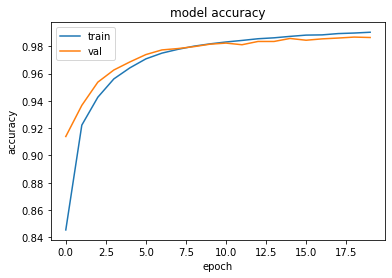

In [36]:
plot_accuracy(history_digits)

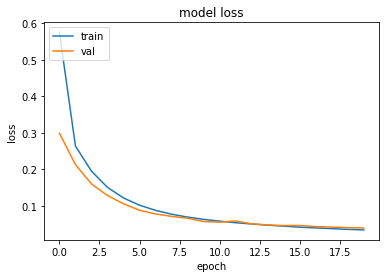

In [37]:
plot_loss(history_digits)

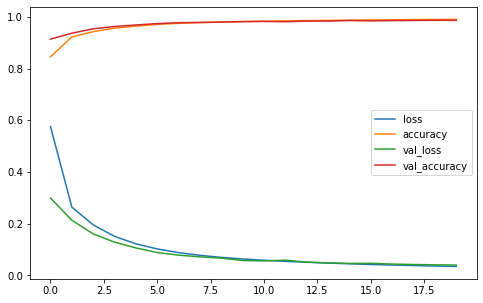

In [38]:
pd.DataFrame(history_digits.history).plot(figsize=(8,5))
plt.show()

In [39]:
# To save the trained model
model_digits.save('model_digits.h5')

# To save the trained weights
model_digits.save_weights('model_digits_weights.h5')

## Instantiate and Train LesNet5 for Alphabet classification

In [40]:
# instantiate model object
model_letters = LeNetFive(27, 'LeNet_for_Alphabets').leNetModel()

# print summary
model_letters.summary()

Model: "LeNet_for_Alphabets"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 28, 28, 1)]       0         
                                                                 
 resize_input (Resizing)     (None, 32, 32, 1)         0         
                                                                 
 c1 (Conv2D)                 (None, 28, 28, 6)         156       
                                                                 
 s2 (AveragePooling2D)       (None, 14, 14, 6)         0         
                                                                 
 c3 (Conv2D)                 (None, 10, 10, 16)        2416      
                                                                 
 s4 (AveragePooling2D)       (None, 5, 5, 16)          0         
                                                                 
 c5 (Conv2D)                 (None, 1, 1, 120) 

In [41]:
tf.keras.utils.plot_model(model_letters,show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [42]:
model_letters.compile(
    optimizer = 'SGD',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy'])
# fit 
history_letters = model_letters.fit(train_x_letters, train_y_letters, validation_data=(test_x_letters, test_y_letters), batch_size=32, epochs=20)
model_letters.evaluate(test_x_letters, test_y_letters)

Epoch 1/20
3900/3900 [==============================] - 16s 4ms/step - loss: 1.3019 - accuracy: 0.6460 - val_loss: 0.7826 - val_accuracy: 0.7775
Epoch 2/20
3900/3900 [==============================] - 16s 4ms/step - loss: 0.6215 - accuracy: 0.8205 - val_loss: 0.5204 - val_accuracy: 0.8494
Epoch 3/20
3900/3900 [==============================] - 15s 4ms/step - loss: 0.4512 - accuracy: 0.8655 - val_loss: 0.4114 - val_accuracy: 0.8782
Epoch 4/20
3900/3900 [==============================] - 15s 4ms/step - loss: 0.3725 - accuracy: 0.8863 - val_loss: 0.3593 - val_accuracy: 0.8918
Epoch 5/20
3900/3900 [==============================] - 16s 4ms/step - loss: 0.3273 - accuracy: 0.8981 - val_loss: 0.3291 - val_accuracy: 0.8993
Epoch 6/20
3900/3900 [==============================] - 15s 4ms/step - loss: 0.2977 - accuracy: 0.9067 - val_loss: 0.3064 - val_accuracy: 0.9045
Epoch 7/20
3900/3900 [==============================] - 17s 4ms/step - loss: 0.2757 - accuracy: 0.9124 - val_loss: 0.2932 - val_ac

[0.22364118695259094, 0.9270672798156738]

### Model accuracy, model loss, and save model for LeNet5 for alphabet classification

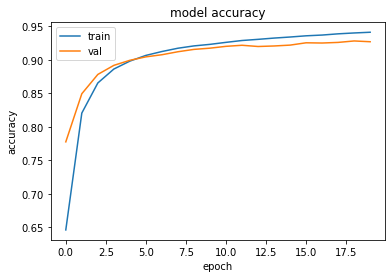

In [43]:
plot_accuracy(history_letters)

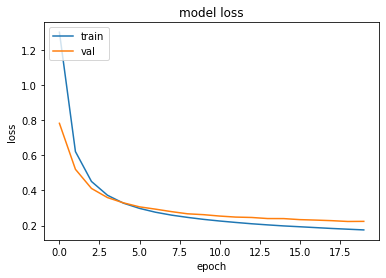

In [44]:
plot_loss(history_letters)

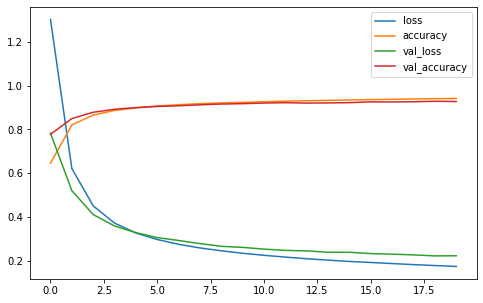

In [45]:
pd.DataFrame(history_letters.history).plot(figsize=(8,5))
plt.show()

In [46]:
# To save the trained model
model_letters.save('letters_model.h5')

# To save the trained weights
model_letters.save_weights('letters_model_weights.h5')

## Instantiate and Train LesNet5 for Baybayin character classification

In [47]:
# instantiate model object
model_baybayin = LeNetFive(17, 'LeNet_for_Baybayin').leNetModel()

# print summary
model_baybayin.summary()

Model: "LeNet_for_Baybayin"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 28, 28, 1)]       0         
                                                                 
 resize_input (Resizing)     (None, 32, 32, 1)         0         
                                                                 
 c1 (Conv2D)                 (None, 28, 28, 6)         156       
                                                                 
 s2 (AveragePooling2D)       (None, 14, 14, 6)         0         
                                                                 
 c3 (Conv2D)                 (None, 10, 10, 16)        2416      
                                                                 
 s4 (AveragePooling2D)       (None, 5, 5, 16)          0         
                                                                 
 c5 (Conv2D)                 (None, 1, 1, 120)  

In [48]:
tf.keras.utils.plot_model(model_baybayin,show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [49]:
model_baybayin.compile(
    optimizer = 'SGD',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy'])
# fit 
history_baybayin = model_baybayin.fit(train_x_baybayin, train_y_baybayin, validation_data=(test_x_baybayin, test_y_baybayin), batch_size=32, epochs=20)
model_baybayin.evaluate(test_x_baybayin, test_y_baybayin)

Epoch 1/20
957/957 [==============================] - 5s 5ms/step - loss: 1.2831 - accuracy: 0.7013 - val_loss: 0.5587 - val_accuracy: 0.8659
Epoch 2/20
957/957 [==============================] - 4s 4ms/step - loss: 0.4775 - accuracy: 0.8795 - val_loss: 0.3801 - val_accuracy: 0.9041
Epoch 3/20
957/957 [==============================] - 4s 4ms/step - loss: 0.3609 - accuracy: 0.9054 - val_loss: 0.3054 - val_accuracy: 0.9217
Epoch 4/20
957/957 [==============================] - 4s 4ms/step - loss: 0.2971 - accuracy: 0.9221 - val_loss: 0.2548 - val_accuracy: 0.9352
Epoch 5/20
957/957 [==============================] - 4s 4ms/step - loss: 0.2543 - accuracy: 0.9324 - val_loss: 0.2221 - val_accuracy: 0.9465
Epoch 6/20
957/957 [==============================] - 4s 4ms/step - loss: 0.2218 - accuracy: 0.9415 - val_loss: 0.1970 - val_accuracy: 0.9507
Epoch 7/20
957/957 [==============================] - 4s 4ms/step - loss: 0.1962 - accuracy: 0.9477 - val_loss: 0.1784 - val_accuracy: 0.9572
Epoch 

[0.08863815665245056, 0.978518545627594]

### Model accuracy, model loss, and save model for LeNet5 for baybayin character classification

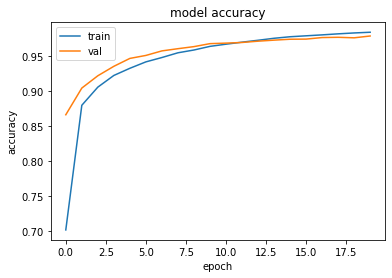

In [50]:
plot_accuracy(history_baybayin)

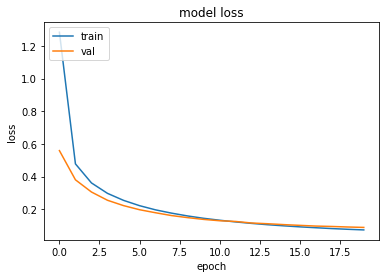

In [51]:
plot_loss(history_baybayin)

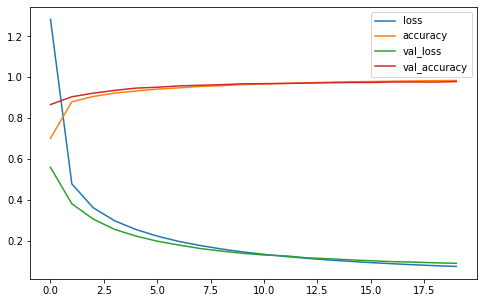

In [52]:
pd.DataFrame(history_baybayin.history).plot(figsize=(8,5))
plt.show()

In [53]:
# To save the trained model
model_baybayin.save('baybayin_model.h5')

# To save the trained weights
model_baybayin.save_weights('baybayin_model_weights.h5')

# **Loading trained models**

In [31]:
model_dir = 'LeNet5_implemetation'

## LeNet5 for digits classification

In [32]:
# To load the trained model
new_model2 = tf.keras.models.load_model(os.path.join(model_dir, 'model_digits.h5')) 

# To load the trained weights to the model used
# digits_model.load_weights('model_digits_weights.h5')

new_model2.summary()

Model: "LeNet_for_digits"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 28, 28, 1)]       0         
                                                                 
 resize_input (Resizing)     (None, 32, 32, 1)         0         
                                                                 
 c1 (Conv2D)                 (None, 28, 28, 6)         156       
                                                                 
 s2 (AveragePooling2D)       (None, 14, 14, 6)         0         
                                                                 
 c3 (Conv2D)                 (None, 10, 10, 16)        2416      
                                                                 
 s4 (AveragePooling2D)       (None, 5, 5, 16)          0         
                                                                 
 c5 (Conv2D)                 (None, 1, 1, 120)    

In [33]:
new_model2.evaluate(x_test, y_test)

313/313 [==============================] - 3s 3ms/step - loss: 0.0398 - accuracy: 0.9864


[0.039781734347343445, 0.9864000082015991]

### Digit Prediction

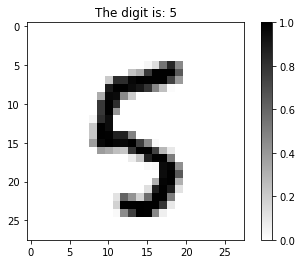



The predictied digit is 5 with a 0.9996099 probability


In [34]:
# Show digit image with true label in the title that returns a random image from the show_data function
test_img = show_data(x_test, y_test)
test_img = np.expand_dims(test_img, axis=0)

# Show predicted class of the random image
pred_arr = new_model2.predict(test_img)
print('\n\nThe predictied digit is', pred_arr.argmax(), 'with a', pred_arr.max(), 'probability')

## LeNet5 for alphabet classification

In [35]:
# To load the trained model
new_model = tf.keras.models.load_model(os.path.join(model_dir, 'letters_model.h5'))

# To load the trained weights to the model used
# letters_model.load_weights('letters_model_weights.h5')

new_model.summary()

Model: "LeNet_for_Alphabets"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 28, 28, 1)]       0         
                                                                 
 resize_input (Resizing)     (None, 32, 32, 1)         0         
                                                                 
 c1 (Conv2D)                 (None, 28, 28, 6)         156       
                                                                 
 s2 (AveragePooling2D)       (None, 14, 14, 6)         0         
                                                                 
 c3 (Conv2D)                 (None, 10, 10, 16)        2416      
                                                                 
 s4 (AveragePooling2D)       (None, 5, 5, 16)          0         
                                                                 
 c5 (Conv2D)                 (None, 1, 1, 120) 

In [36]:
new_model.evaluate(test_x_letters, test_y_letters)

650/650 [==============================] - 2s 2ms/step - loss: 0.2236 - accuracy: 0.9271


[0.22364118695259094, 0.9270672798156738]

### Alphabet Prediction

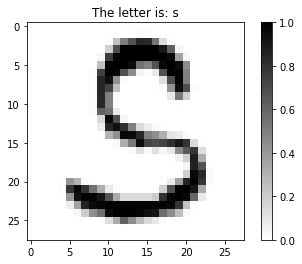



The predictied letter is s with a 0.9976665 probability


In [37]:
import string

# Show alphabet image with true label in the title that returns a random image from the show_data function
test_img = show_data(test_x_letters, test_y_letters, False)
test_img = np.expand_dims(test_img, axis=0)

# Show predicted class of the random image
pred_arr = new_model.predict(test_img)
print('\n\nThe predictied letter is', string.ascii_lowercase[pred_arr.argmax()-1], 'with a', pred_arr.max(), 'probability')

## LeNet5 for baybayin character classification

In [38]:
# To load the trained model
new_model3 = tf.keras.models.load_model(os.path.join(model_dir, 'baybayin_model.h5'))

# To load the trained weights to the model used
# letters_model.load_weights('baybayin_model_weights.h5')

new_model3.summary()

Model: "LeNet_for_Baybayin"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 28, 28, 1)]       0         
                                                                 
 resize_input (Resizing)     (None, 32, 32, 1)         0         
                                                                 
 c1 (Conv2D)                 (None, 28, 28, 6)         156       
                                                                 
 s2 (AveragePooling2D)       (None, 14, 14, 6)         0         
                                                                 
 c3 (Conv2D)                 (None, 10, 10, 16)        2416      
                                                                 
 s4 (AveragePooling2D)       (None, 5, 5, 16)          0         
                                                                 
 c5 (Conv2D)                 (None, 1, 1, 120)  

In [39]:
new_model3.evaluate(test_x_baybayin, test_y_baybayin)

169/169 [==============================] - 1s 3ms/step - loss: 0.0886 - accuracy: 0.9785


[0.08863815665245056, 0.978518545627594]

### Baybayin Character Prediction

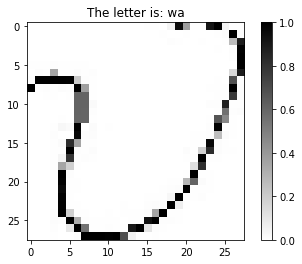



The predictied baybayin character is wa with a 0.9878271 probability


In [41]:
import string
baybayin_list = ['a', 'ba', 'dara', 'ei', 'ga', 'ha', 'ka', 'la', 'ma', 'na', 'nga', 'ou', 'pa', 'sa', 'ta', 'wa', 'ya']

# Show baybayin character image with true label in the title that returns a random image from the show_data function
test_img = show_data2(test_x_baybayin, test_y_baybayin)
test_img = np.expand_dims(test_img, axis=0)

# Show predicted class of the random image
pred_arr = new_model3.predict(test_img)
print('\n\nThe predictied baybayin character is', baybayin_list[pred_arr.argmax()], 'with a', pred_arr.max(), 'probability')